# Lesson 6 "Differential Privacy for Deep Learning" project

## Scenario description 


Training set: 60000 labeled images. This will be split in 20 slices of 3000 labeled images to generate the private models.
Test set: 10000 images.
The test set will have 2 purposes:
 - To help measure the training accuracy (using its labels for this)
 - To act as the "public dataset", by ignoring its labels. This is the main purpose of the testset
 
 Steps

- 1) Train the 20 private models with the trainset
- 2) Use the 20 partner models to predict on the local dataset (the testset), generating 20 labels for each of the datapoints
- 3) Then, for each local data point (now with 20 labels), perform a maxcount query to get the most frequent label across the 20 labels. 
- 4) Add laplacian noise to the maxcounts to make this Differentially Private to a certain epsilon/delta constraint.
- 5) Finally, we will retrain a new model on our local dataset which now has labels (the noised ones). This will be our final "DP" model.
- 5) Do the PATE analysis to find the total epsilon used.

# Project implementation

This project will use the MNIST dataset, provided below.

In [102]:
# import torchvision.datasets as datasets
from torchvision import transforms, datasets

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor()
    ###transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

mnist_testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [103]:
train_data = mnist_trainset.train_data
train_targets = mnist_trainset.train_labels

In [104]:
test_data = mnist_testset.test_data
test_targets = mnist_testset.test_labels

In [106]:
#mnist_trainset.test_data.sum() == mnist_trainset.train_data.sum() True
#mnist_testset.test_data.sum() == mnist_testset.train_data.sum() True
#mnist_testset.test_data.shape

In [107]:
train_data.shape

torch.Size([60000, 28, 28])

In [108]:
test_data.shape

torch.Size([10000, 28, 28])

In [109]:
len(mnist_trainset)

60000

In [115]:
import time
import torch
from torch import nn, optim
import torch.nn.functional as F

print('Device: ', torch.device("cuda" if torch.cuda.is_available() else "cpu"))
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)                        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
        # Use GPU if it's available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device);
        
    def get_device(self):
        return "cuda" if next(self.parameters()).is_cuda else "cpu"
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))        
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x
    
    def predict_dataset(self, dataloader):
        model = self
        #predictions = list()
        predictions = torch.tensor([]).long()
        with torch.no_grad():
            for images, _ in dataloader:
                images = images.to(self.get_device())
                log_ps = model.forward(images)                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                prediction = top_class.view(top_class.shape[0])
                #print('prediction.shape', prediction.shape)
                predictions = torch.cat((predictions, prediction), 0)
                #predictions.append(prediction)
                
        return predictions
    
    def log_time_and_reset(self, start, message = "{:.4f} seconds"):
        new_start = time.time()
        #print(f"Device = {self.get_device()}; Last train batch time: {(time.time() - start):.4f} seconds") #Added by Edgarin        
        #print((message + " {:.4f} seconds").format(new_start - start)) #Added by Edgarin
        print((message + " {:.0f} ms").format((new_start - start)*1000)) #Added by Edgarin
        return new_start
    
    
    def train_and_test(self, trainloader, testloader, epochs = 1):
        # Copied from Part 5 - Inference and Validation (Solution).ipynb
        # Just added the cuda
        model = self
        
        criterion = nn.NLLLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.003)

        # epochs = 30  #Only thing changed from original
        steps = 0

        train_losses, test_losses = [], []
        for e in range(epochs):
            print('Epoch {}'.format(e+1))
            running_loss = 0
            b = 0
            epoch_start = time.time()
            start = time.time()
            for images, labels in trainloader:                
                print('  batch: ', b)
                start = self.log_time_and_reset(start, "    Get batch:")
                b += 1                
                #start = time.time() #Added by Edgarin
                images, labels = images.to(self.get_device()), labels.to(self.get_device()) # Added by Edgarin
                start = self.log_time_and_reset(start, "    Move to device:")
                # images = images.view(images.shape[0], -1)
                optimizer.zero_grad()
                log_ps = model.forward(images)
                start = self.log_time_and_reset(start, "    model.forward(): ")
                loss = criterion(log_ps, labels)
                loss.backward()
                optimizer.step()
                start = self.log_time_and_reset(start, "    backward and step: ")
                running_loss += loss.item()            
                        
            #else:
            print(f"  Epoch time: {(time.time() - epoch_start):.4f} seconds") #Added by Edgarin
            if(False):                
                test_loss = 0
                accuracy = 0
                
                # Turn off gradients for validation, saves memory and computations                
                with torch.no_grad():
                    model.eval()
                    for images, labels in testloader:
                        start = time.time() #Added by Edgarin
                        images, labels = images.to(self.get_device()), labels.to(self.get_device()) # Added by Edgarin
                        # images = images.view(images.shape[0], -1)                        
                        log_ps = model.forward(images)
                        test_loss += criterion(log_ps, labels)

                        ps = torch.exp(log_ps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor))
                    #print(f"Device = {self.get_device()}; Last test batch time: {(time.time() - start):.4f} seconds") #Added by Edgarin

                model.train()

                train_losses.append(running_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))

                print("Epoch: {}/{} ".format(e+1, epochs),
                      "Training Loss: {:.3f} ".format(running_loss/len(trainloader)),
                      "Test Loss: {:.3f} ".format(test_loss/len(testloader)),
                      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
    


Device:  cuda


In [116]:
trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=16384, shuffle=False)
testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=8192, shuffle=False)


In [117]:
for device in ['cpu', 'cuda']:  
    print('---', device, '---')
    ## Test training a model
    start = time.time()
    model1 = Classifier()
    model1.to(device)    
    model1.train_and_test(trainloader, testloader, 1)
    print(f"Device = {model1.get_device()}; Whole time: {(time.time() - start):.4f} seconds") #Added by Edgarin
print('done')    


--- cpu ---
Epoch 1
  batch:  0
    Get batch: 3342 ms
    Move to device: 0 ms
    model.forward():  81 ms
    backward and step:  71 ms
  batch:  1
    Get batch: 3287 ms
    Move to device: 0 ms
    model.forward():  82 ms
    backward and step:  69 ms
  batch:  2
    Get batch: 3241 ms
    Move to device: 0 ms
    model.forward():  80 ms
    backward and step:  72 ms
  batch:  3
    Get batch: 2144 ms
    Move to device: 0 ms
    model.forward():  52 ms
    backward and step:  45 ms
  Epoch time: 12.5660 seconds
Device = cpu; Whole time: 12.5870 seconds
--- cuda ---
Epoch 1
  batch:  0
    Get batch: 3270 ms
    Move to device: 20 ms
    model.forward():  2 ms
    backward and step:  7 ms
  batch:  1
    Get batch: 3318 ms
    Move to device: 22 ms
    model.forward():  2 ms
    backward and step:  6 ms
  batch:  2
    Get batch: 3380 ms
    Move to device: 21 ms
    model.forward():  2 ms
    backward and step:  9 ms
  batch:  3
    Get batch: 2291 ms
    Move to device: 15 ms
   

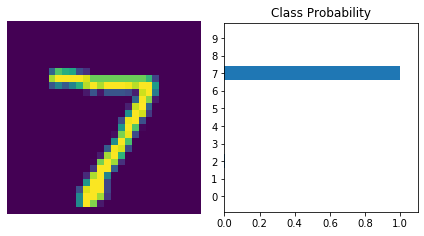

In [11]:
%matplotlib inline
import helper

images, labels = next(iter(testloader))
img = images[0] #.view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model1.forward(img.to(model1.get_device())).cpu()

# Output of the network are logits, need to take softmax for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)

In [13]:
from torch.utils.data import SubsetRandomSampler 

def get_trainloader_slice(i, slice_size):    
    train_indices = range(int(i*slice_size), int((i+1)*slice_size))
    trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=False, sampler=SubsetRandomSampler(train_indices))
    return trainloader

models = list()
train_size = len(mnist_trainset)
n_teachers = 200
n_slices = n_teachers  #n_slices is deprecated
slice_size = train_size / n_slices

for i in range(n_slices):
    print('Training slice ', i, '...')
    new_model = Classifier()
    print('is_cuda', next(new_model.parameters()).is_cuda)
    new_trainloader = get_trainloader_slice(i, slice_size)
    new_model.train_and_test(new_trainloader, testloader, 8)
    models.append(new_model)    
len(models)    

Training slice  0 ...
is_cuda True
Epoch 1
Epoch: 1/8  Training Loss: 2.198  Test Loss: 2.018  Test Accuracy: 0.473
Epoch 2
Epoch: 2/8  Training Loss: 1.726  Test Loss: 1.535  Test Accuracy: 0.610
Epoch 3
Epoch: 3/8  Training Loss: 1.186  Test Loss: 1.119  Test Accuracy: 0.678
Epoch 4
Epoch: 4/8  Training Loss: 0.787  Test Loss: 0.905  Test Accuracy: 0.719
Epoch 5
Epoch: 5/8  Training Loss: 0.607  Test Loss: 0.789  Test Accuracy: 0.744
Epoch 6
Epoch: 6/8  Training Loss: 0.471  Test Loss: 0.821  Test Accuracy: 0.749
Epoch 7
Epoch: 7/8  Training Loss: 0.361  Test Loss: 0.728  Test Accuracy: 0.773
Epoch 8
Epoch: 8/8  Training Loss: 0.341  Test Loss: 0.723  Test Accuracy: 0.769
Training slice  1 ...
is_cuda True
Epoch 1
Epoch: 1/8  Training Loss: 2.232  Test Loss: 2.050  Test Accuracy: 0.516
Epoch 2
Epoch: 2/8  Training Loss: 1.841  Test Loss: 1.596  Test Accuracy: 0.588
Epoch 3
Epoch: 3/8  Training Loss: 1.317  Test Loss: 1.113  Test Accuracy: 0.732
Epoch 4
Epoch: 4/8  Training Loss: 0.86

Epoch: 1/8  Training Loss: 2.231  Test Loss: 2.065  Test Accuracy: 0.403
Epoch 2
Epoch: 2/8  Training Loss: 1.869  Test Loss: 1.655  Test Accuracy: 0.643
Epoch 3
Epoch: 3/8  Training Loss: 1.334  Test Loss: 1.216  Test Accuracy: 0.713
Epoch 4
Epoch: 4/8  Training Loss: 0.956  Test Loss: 0.918  Test Accuracy: 0.736
Epoch 5
Epoch: 5/8  Training Loss: 0.655  Test Loss: 0.776  Test Accuracy: 0.765
Epoch 6
Epoch: 6/8  Training Loss: 0.528  Test Loss: 0.733  Test Accuracy: 0.774
Epoch 7
Epoch: 7/8  Training Loss: 0.374  Test Loss: 0.752  Test Accuracy: 0.766
Epoch 8
Epoch: 8/8  Training Loss: 0.336  Test Loss: 0.696  Test Accuracy: 0.792
Training slice  13 ...
is_cuda True
Epoch 1
Epoch: 1/8  Training Loss: 2.239  Test Loss: 2.108  Test Accuracy: 0.407
Epoch 2
Epoch: 2/8  Training Loss: 1.896  Test Loss: 1.682  Test Accuracy: 0.571
Epoch 3
Epoch: 3/8  Training Loss: 1.392  Test Loss: 1.181  Test Accuracy: 0.723
Epoch 4
Epoch: 4/8  Training Loss: 0.954  Test Loss: 0.845  Test Accuracy: 0.776


KeyboardInterrupt: 

In [ ]:
n_testset = len(mnist_testset)
with torch.no_grad():    
    private_label_matrix = torch.zeros(len(models), n_testset).long()
    for i in range(len(models)):
        model = models[i]
        predictions = model.predict_dataset(testloader)        
        private_label_matrix[i] = predictions
    print(private_label_matrix.shape)

In [ ]:
import numpy as np
def getLaplacianNoise(sensitivity, epsilon):
    b = sensitivity / epsilon
    return np.random.laplace(0, b, 1)

In [ ]:
dp_labels = torch.zeros(n_testset).long()
epsilon = 0.1
sensitivity = 1
nondp_labels = torch.zeros(n_testset).long()
for i in range(n_testset):
    private_labels = private_label_matrix[:,i].bincount(minlength=10)
    
    # print(private_labels.tolist())
    noised_labels = list(map(lambda l: l + getLaplacianNoise(sensitivity, epsilon)[0], private_labels.tolist()))
  
    dp_labels[i] = int(np.argmax(noised_labels))
    nondp_labels[i] = int(np.argmax(private_labels.tolist()))

dp_labels
nondp_labels

In [ ]:
## Test accuracy
equals = dp_labels == mnist_testset.targets
accuracy = torch.mean(equals.type(torch.FloatTensor))    
print('DP model accuracy: ', accuracy)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
# mnist_testset.test_data.shape
# torch.Size([10000, 28, 28])
images = mnist_testset.test_data.float() / 255  # Needed for normalization

dataset = TensorDataset(images, dp_labels.long())
dploader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
dpmodel = Classifier()
dpmodel.train_and_test(dploader, testloader, 8)


In [ ]:
from syft.frameworks.torch.differential_privacy import pate

data_dep_eps, data_ind_eps = pate.perform_analysis(
    teacher_preds=private_label_matrix.numpy().astype(int), 
    indices=nondp_labels.numpy().astype(int), 
    noise_eps=0.001, 
    delta=1e-5,
    moments=100
)

# assert data_dep_eps <= data_ind_eps

In [ ]:
print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)